In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import ast
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import sklearn

In [2]:
json_file = 'EternaBench_Riboswitch_Filtered_23May2022.json.zip'

data = pd.read_json(json_file)
data = data.reset_index(drop=True)
data.shape
data.head()

,Activation Ratio,Design,Folding_Subscore,KDFMN,KDOFF,KDON,KDnoFMN,Kd_OFF,Kd_ON,NumberOfClusters,...,lig_aptamer,MS2_lig_aptamer,constraints_worked,logkd_nolig,logkd_lig,logkd_nolig_scaled,logkd_lig_scaled,Dataset,passed_CDHIT_filter,log_AR
0,0.985644,None,NaN,NaN,8.688763,8.815313,NaN,8.688763,8.815313,NaN,...,..........(xxxxx(.................)xxxxxx).......,..........(xxxxx(.................)xxxxxx)...(...,0,2.176490,2.162031,1.075144,1.060684,Ribologic_FMN,True,-0.014460
1,0.638712,None,NaN,NaN,68.275500,106.895529,NaN,68.275500,106.895529,NaN,...,..........(xxxxxx(...............................,..........(xxxxxx(.........................(((...,0,4.671852,4.223551,3.570506,3.122205,Ribologic_FMN,True,-0.448301
2,1.195391,None,NaN,NaN,9.479632,7.930152,NaN,9.479632,7.930152,NaN,...,..........(xxxxxx(.................)xxxxx).......,..........(xxxxxx(.................)xxxxx).......,0,2.070672,2.249146,0.969326,1.147799,Ribologic_FMN,True,0.178473
3,0.827836,None,NaN,NaN,37.213889,44.953230,NaN,37.213889,44.953230,NaN,...,..........(xxxxxx(.................)xxxxx).......,..........(xxxxxx(.................)xxxxx).......,0,3.805623,3.616682,2.704276,2.515336,Ribologic_FMN,True,-0.188941
4,1.002273,None,NaN,NaN,198.475109,198.024952,NaN,198.475109,198.024952,NaN,...,..........(xxxxxx(.................)xxxxx).......,..........(xxxxxx(.................)xxxxx).......,0,5.288393,5.290664,4.187047,4.189317,Ribologic_FMN,True,0.002271


In [3]:
data.columns

Index(['Activation Ratio', 'Design', 'Folding_Subscore', 'KDFMN', 'KDOFF',
       'KDON', 'KDnoFMN', 'Kd_OFF', 'Kd_ON', 'NumberOfClusters', 'Player',
       'Puzzle_Name', 'Round', 'index', 'ligand', 'min_kd_val', 'puzzle',
       'sequence', 'switch', 'MS2_aptamer', 'lig_aptamer', 'MS2_lig_aptamer',
       'constraints_worked', 'logkd_nolig', 'logkd_lig', 'logkd_nolig_scaled',
       'logkd_lig_scaled', 'Dataset', 'passed_CDHIT_filter', 'log_AR'],
      dtype='object')

In [4]:
data['Dataset'].unique()

array(['Ribologic_FMN', 'Ribologic_Theo', 'Ribologic_Trp', '1_FMN',
       '2_FMN', '3_FMN', '4_FMN', '5_FMN', '6_FMN', '7_FMN', '8_Theo',
       '8_Trp'], dtype=object)

In [5]:
# Group the data by the 'Dataset' column and store each group as a separate dataframe in a dictionary
dataset_dict = {dataset: group for dataset, group in data.groupby('Dataset')}

# Now you can access each dataframe by its dataset name, for example:
ribologic_fmn_data = dataset_dict['Ribologic_FMN']
ribologic_theo_data = dataset_dict['Ribologic_Theo']
ribologic_trp_data = dataset_dict['Ribologic_Trp']

# Print the first few rows of any dataframe to check
print(ribologic_theo_data.head())

#Did this to figure out what the different Kd values were in the .json file - it seem like KDON and Kd_ON are the same , as well as the KD_offs,
#I am going to finetune on both KDON and KDOFF values, but using to predict KDON

      Activation Ratio Design  Folding_Subscore  KDFMN       KDOFF       KDON  \
2140          1.002954   None               NaN    NaN   13.218001  13.179067   
2141          2.984702   None               NaN    NaN   49.747634  16.667538   
2142          2.601194   None               NaN    NaN   83.884971  32.248645   
2143          1.328070   None               NaN    NaN   29.284715  22.050575   
2144          3.891551   None               NaN    NaN  325.787577  83.716637   

      KDnoFMN      Kd_OFF      Kd_ON  NumberOfClusters  ...  \
2140      NaN   13.218001  13.179067               NaN  ...   
2141      NaN   49.747634  16.667538               NaN  ...   
2142      NaN   83.884971  32.248645               NaN  ...   
2143      NaN   29.284715  22.050575               NaN  ...   
2144      NaN  325.787577  83.716637               NaN  ...   

                                            lig_aptamer  \
2140  ...........................(xxx((((..............   
2141  ..........

In [6]:
# Filter for dataframes with keys that start with 'Ribologic'
ribologic_dfs = [df for key, df in dataset_dict.items() if key.startswith('Ribologic')]
#test_dfs = [df for key, df in dataset_dict.items() if key.startswith('1_FMN')] #Should repeat this with all the other unique datasets
# Concatenate them into a single dataframe
combined_ribologic_df = pd.concat(ribologic_dfs, ignore_index=True)
#combined_val_df = pd.concat(val_dfs, ignore_index=True )
# Print the first few rows of the combined dataframe to check
#print(combined_ribologic_df.head())
import pandas as pd
from sklearn.model_selection import train_test_split


# Step 1: Filter data for training, validation, and test sets
train_data = combined_ribologic_df  # Training data: Ribologic_FMN
test_data = data[data['Dataset'].isin(['1_FMN', '2_FMN', '3_FMN', '4_FMN', '5_FMN', '6_FMN', '7_FMN','8_Theo',
       '8_Trp'])]  # Test data

# Step 2: Split the training data into training and validation sets
# Here, you can split `train_data` further into a training and validation set (e.g., 80% training, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Step 3: Check the split
print(f"Total Data Side: {data.shape[0]}")
print(f"Training Data Size: {train_data.shape[0]}")
print(f"Validation Data Size: {val_data.shape[0]}")
print(f"Test Data Size: {test_data.shape[0]}")

Total Data Side: 7228
Training Data Size: 2006
Validation Data Size: 502
Test Data Size: 4720


In [7]:
train_data.columns

Index(['Activation Ratio', 'Design', 'Folding_Subscore', 'KDFMN', 'KDOFF',
       'KDON', 'KDnoFMN', 'Kd_OFF', 'Kd_ON', 'NumberOfClusters', 'Player',
       'Puzzle_Name', 'Round', 'index', 'ligand', 'min_kd_val', 'puzzle',
       'sequence', 'switch', 'MS2_aptamer', 'lig_aptamer', 'MS2_lig_aptamer',
       'constraints_worked', 'logkd_nolig', 'logkd_lig', 'logkd_nolig_scaled',
       'logkd_lig_scaled', 'Dataset', 'passed_CDHIT_filter', 'log_AR'],
      dtype='object')

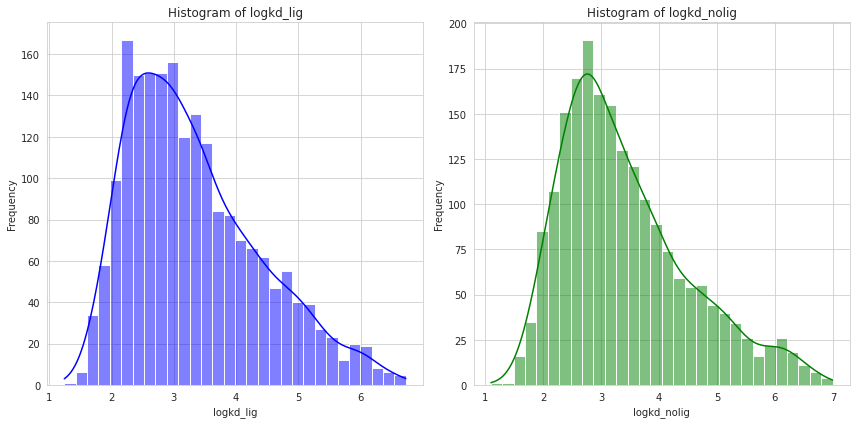

In [8]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Plot the histogram for 'logkd_lig'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['logkd_lig'], kde=True, color='blue', bins=30)
plt.title('Histogram of logkd_lig')
plt.xlabel('logkd_lig')
plt.ylabel('Frequency')

# Plot the histogram for 'logkd_nolig'
plt.subplot(1, 2, 2)
sns.histplot(train_data['logkd_nolig'], kde=True, color='green', bins=30)
plt.title('Histogram of logkd_nolig')
plt.xlabel('logkd_nolig')
plt.ylabel('Frequency')

# Adjust layout to make space for titles and labels
plt.tight_layout()

# Show the plots
plt.show()


In [9]:
2006 + 502 + 4720

7228

In [10]:
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [11]:
train_data.columns

Index(['Activation Ratio', 'Design', 'Folding_Subscore', 'KDFMN', 'KDOFF',
       'KDON', 'KDnoFMN', 'Kd_OFF', 'Kd_ON', 'NumberOfClusters', 'Player',
       'Puzzle_Name', 'Round', 'index', 'ligand', 'min_kd_val', 'puzzle',
       'sequence', 'switch', 'MS2_aptamer', 'lig_aptamer', 'MS2_lig_aptamer',
       'constraints_worked', 'logkd_nolig', 'logkd_lig', 'logkd_nolig_scaled',
       'logkd_lig_scaled', 'Dataset', 'passed_CDHIT_filter', 'log_AR'],
      dtype='object')

# Define Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval

class RNA_Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokens = {nt: i for i, nt in enumerate('ACGU')}
        self.label_names = ['logkd_lig', 'logkd_nolig']
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in (self.data.loc[idx,'sequence'])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)
        
        labels = np.array([self.data.loc[idx, l] for l in self.label_names])  # Just 1 value per label
        labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are of correct float type
        

        return {'sequence': sequence, 'labels': labels}



In [13]:
# Create the datasets
train_dataset = RNA_Dataset(train_data)
val_dataset = RNA_Dataset(val_data)

# Test the first sample
print(train_dataset[0]['labels'].shape)


torch.Size([2])


In [14]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)


In [15]:
! pip install einops

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import sys

sys.path.append('/scratch/groups/rhiju/gtully/rnet2d/sherlock_file_organization/ribonanzanet2d-final')


from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config, pretrained=False):
        super(finetuned_RibonanzaNet, self).__init__(config)
        if pretrained:
            self.load_state_dict(torch.load('/scratch/groups/rhiju/gtully/rnet2d/sherlock_file_organization/ribonanzanet-weights/RibonanzaNet.pt',map_location='cpu'))
        
        self.global_pool = nn.AdaptiveAvgPool2d(1) 
        self.decoder = nn.Linear(64, 2)  # From 64 "pooled values from each channel " to 2 output labels

    def forward(self,src):

        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))
        #sequence_feature = sequence_features
        #output=self.decoder(output)
        #output = output.sum(1)
        #ouput = output.mean(1)
        #output = output.squeeze(0)
        #output = output.mean(0)
        #output = output.squeeze(0)
        #output=output.mean(1)
        # x has shape [1, H, W, 64]
        pairwise_features = pairwise_features.squeeze(0)  # Remove the batch dimension to make it [H, W, 64]
        pairwise_features = pairwise_features.permute(2, 0, 1)  # Change to [64, H, W] to match pooling expectation (C, H, W)

        # Apply global average pooling, result is [64, 1, 1]
        pairwise_features = self.global_pool(pairwise_features)

        # Flatten the output to [64]
        pairwise_features = pairwise_features.view(pairwise_features.size(0))  # Flatten to [64] (batch size 1, so this will be [64])

        # Pass through the decoder to get the final output [2]
        output = self.decoder(pairwise_features)

        return output

In [17]:
config=load_config_from_yaml("/scratch/groups/rhiju/gtully/rnet2d/sherlock_file_organization/ribonanzanet2d-final/configs/pairwise.yaml")
model=finetuned_RibonanzaNet(config,pretrained=False).cuda()



constructing 9 ConvTransformerEncoderLayers


###Training Loop

In [18]:
! git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

fatal: destination path 'Ranger-Deep-Learning-Optimizer' already exists and is not an empty directory.


In [19]:
import sys
sys.path.append('/home/groups/rhiju/gtully/RS_dataset_finetuning/Ranger-Deep-Learning-Optimizer/ranger')
from ranger import Ranger
from tqdm import tqdm

# Loss function

epochs = 20
cos_epoch = 15

best_loss = np.inf
optimizer = Ranger(model.parameters(), weight_decay=0.001, lr=0.0001)

criterion = torch.nn.L1Loss()

schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(epochs - cos_epoch) * len(train_loader))


for epoch in range(epochs):
    model.train()
    tbar = tqdm(train_loader)
    total_loss = 0
    oom = 0
    for idx, batch in enumerate(tbar):
        sequence = batch['sequence'].cuda()
        #ligand_type = batch['ligand_type'].cuda()  # New ligand type feature
        labels = batch['labels'].cuda()

        # Pass both sequence and ligand_type to the model
        output = model(sequence)

        # Compute loss
        loss = criterion(output, labels)  # Adjust output shape if needed
        loss = loss.mean()

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        optimizer.zero_grad()

        if (epoch + 1) > cos_epoch:
            schedule.step()

        total_loss += loss.item()
        tbar.set_description(f"Epoch {epoch + 1} Loss: {total_loss / (idx + 1)}")

    # Validation loop
    tbar = tqdm(val_loader)
    model.eval()
    val_preds = []
    val_loss = 0
    for idx, batch in enumerate(tbar):
        sequence = batch['sequence'].cuda()
        #ligand_type = batch['ligand_type'].cuda()  # New ligand type feature
        labels = batch['labels'].cuda()

        with torch.no_grad():
            # Pass both sequence and ligand_type to the model during validation
            output = model(sequence)

            loss = criterion(output, labels)
            loss = loss.mean()

        val_loss += loss.item()
        val_preds.append([labels.cpu().numpy(), output.cpu().numpy()])

    val_loss = val_loss / len(tbar)
    print(f"val loss: {val_loss}")

    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_preds = val_preds
        torch.save(model.state_dict(), 'RibonanzaNet-EB_No_Pretraining_log_kds.pt')


    # 1.053595052265986 train loss after epoch 0
    

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


  0%|          | 0/2006 [00:00<?, ?it/s]/home/users/gtully/.local/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/users/gtully/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/users/gtully/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.au

val loss: 0.9008473131761133


100%|██████████| 502/502 [00:20<00:00, 24.24it/s]


val loss: 0.9372819951805935


100%|██████████| 502/502 [00:20<00:00, 24.03it/s]


val loss: 0.8783717796622045


100%|██████████| 502/502 [00:20<00:00, 24.23it/s]


val loss: 0.8754183981285627


100%|██████████| 502/502 [00:20<00:00, 24.17it/s]


val loss: 0.9223543828227131


100%|██████████| 502/502 [00:20<00:00, 24.20it/s]


val loss: 0.8749905140751386


100%|██████████| 502/502 [00:20<00:00, 23.96it/s]


val loss: 0.8784505793772845


100%|██████████| 502/502 [00:20<00:00, 24.18it/s]


val loss: 0.8728613339334845


100%|██████████| 502/502 [00:20<00:00, 24.02it/s]


val loss: 0.8450856451019347


100%|██████████| 502/502 [00:20<00:00, 24.22it/s]


val loss: 0.856520235301014


100%|██████████| 502/502 [00:20<00:00, 24.09it/s]


val loss: 0.851088994527718


100%|██████████| 502/502 [00:20<00:00, 24.12it/s]


val loss: 0.838652475065444


100%|██████████| 502/502 [00:20<00:00, 24.18it/s]


val loss: 0.8568508838752351


100%|██████████| 502/502 [00:20<00:00, 24.01it/s]


val loss: 0.8284169206343799


100%|██████████| 502/502 [00:20<00:00, 24.15it/s]


val loss: 0.8518381919043948


100%|██████████| 502/502 [00:20<00:00, 24.07it/s]


val loss: 0.8220622458780904


100%|██████████| 502/502 [00:20<00:00, 24.09it/s]


val loss: 0.8275405715898688


100%|██████████| 502/502 [00:20<00:00, 24.20it/s]


val loss: 0.8231395655181778


100%|██████████| 502/502 [00:20<00:00, 24.09it/s]


val loss: 0.8348503696965981


100%|██████████| 502/502 [00:20<00:00, 24.18it/s]

val loss: 0.8374951393955732


In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm

test_dataset = RNA_Dataset(data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the weights and map them to the CPU
#model.load_state_dict(torch.load('RibonanzaNet-EB_06.pt', map_location=torch.device('cpu')))

# Set the model to evaluation mode for inference
model.eval()

# Validation loop
tbar = tqdm(test_loader)
test_preds = []
for idx, batch in enumerate(tbar):
    sequence = batch['sequence'].cuda()
    labels = batch['labels'].cuda()

    with torch.no_grad():
    # Pass both sequence and ligand_type to the model during validation
        output = model(sequence)
        test_preds.append([output.cpu().numpy()])

# Create lists to store the predicted values
log_kfold_est_lig_Z_rnet_eb_8 = []
log_kfold_est_nolig_Z_rnet_eb_8 = []

# Iterate through the 'test_preds' and extract the predictions for each sequence
for pred in test_preds:
    log_kfold_est_lig_Z_rnet_eb_8.append(pred[0][0])  # Index 0 goes to logkd_lig_pred
    log_kfold_est_nolig_Z_rnet_eb_8.append(pred[0][1])  # Index 1 goes to logkd_no_lig_pred

# Create a new DataFrame with the same structure as 'test_data' and the new columns
new_test_data = data.copy()  # Copy the original test_data DataFrame
new_test_data['log_kfold_est_lig_Z_rnet_eb_no_pretraining'] = log_kfold_est_lig_Z_rnet_eb_8  # Add the logkd_lig_pred column
new_test_data['log_kfold_est_nolig_Z_rnet_eb_no_pretraining'] = log_kfold_est_nolig_Z_rnet_eb_8  # Add the logkd_no_lig_pred column

# Display the first few rows of the new DataFrame
new_test_data.head()

100%|██████████| 7228/7228 [04:58<00:00, 24.22it/s]


,Activation Ratio,Design,Folding_Subscore,KDFMN,KDOFF,KDON,KDnoFMN,Kd_OFF,Kd_ON,NumberOfClusters,...,constraints_worked,logkd_nolig,logkd_lig,logkd_nolig_scaled,logkd_lig_scaled,Dataset,passed_CDHIT_filter,log_AR,log_kfold_est_lig_Z_rnet_eb_no_pretraining,log_kfold_est_nolig_Z_rnet_eb_no_pretraining
0,0.985644,None,NaN,NaN,8.688763,8.815313,NaN,8.688763,8.815313,NaN,...,0,2.176490,2.162031,1.075144,1.060684,Ribologic_FMN,True,-0.014460,2.789545,2.945418
1,0.638712,None,NaN,NaN,68.275500,106.895529,NaN,68.275500,106.895529,NaN,...,0,4.671852,4.223551,3.570506,3.122205,Ribologic_FMN,True,-0.448301,4.172306,4.307917
2,1.195391,None,NaN,NaN,9.479632,7.930152,NaN,9.479632,7.930152,NaN,...,0,2.070672,2.249146,0.969326,1.147799,Ribologic_FMN,True,0.178473,2.181423,2.236006
3,0.827836,None,NaN,NaN,37.213889,44.953230,NaN,37.213889,44.953230,NaN,...,0,3.805623,3.616682,2.704276,2.515336,Ribologic_FMN,True,-0.188941,3.055761,3.161803
4,1.002273,None,NaN,NaN,198.475109,198.024952,NaN,198.475109,198.024952,NaN,...,0,5.288393,5.290664,4.187047,4.189317,Ribologic_FMN,True,0.002271,3.578770,3.755002


In [21]:
new_test_data.to_json('RS_rnet_eb_no_pretraining_Z.json')

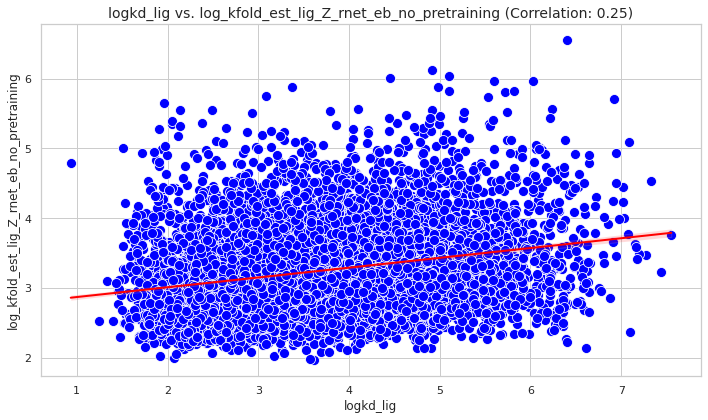

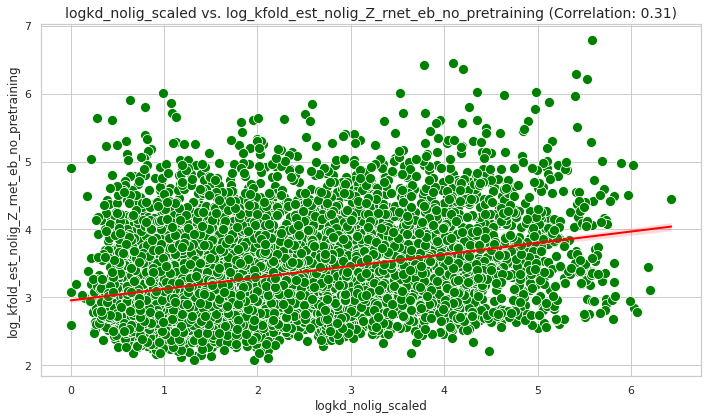

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the style for the plots (optional)
sns.set(style="whitegrid")

# Create a new figure for the first plot (logkd_lig vs. logkd_lig_pred)
plt.figure(figsize=(10, 6))

# Scatter plot for logkd_lig vs. logkd_lig_pred
sns.scatterplot(x=new_test_data['logkd_lig'], y=new_test_data['log_kfold_est_lig_Z_rnet_eb_no_pretraining'], color='blue', s=100)

# Fit a linear regression line for visualization
sns.regplot(x=new_test_data['logkd_lig'], y=new_test_data['log_kfold_est_lig_Z_rnet_eb_no_pretraining'], scatter=False, color='blue', line_kws={"color": "red", "linewidth": 2})

# Calculate the correlation coefficient for logkd_lig vs. logkd_lig_pred
corr_lig = np.corrcoef(new_test_data['logkd_lig'], new_test_data['log_kfold_est_lig_Z_rnet_eb_no_pretraining'])[0, 1]

# Add labels and title
plt.title(f'logkd_lig vs. log_kfold_est_lig_Z_rnet_eb_no_pretraining (Correlation: {corr_lig:.2f})', fontsize=14)
plt.xlabel('logkd_lig', fontsize=12)
plt.ylabel('log_kfold_est_lig_Z_rnet_eb_no_pretraining', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Create a new figure for the second plot (logkd_no_lig vs. logkd_no_lig_pred)
plt.figure(figsize=(10, 6))

# Scatter plot for logkd_nolig vs. logkd_no_lig_pred
sns.scatterplot(x=new_test_data['logkd_nolig_scaled'], y=new_test_data['log_kfold_est_nolig_Z_rnet_eb_no_pretraining'], color='green', s=100)

# Fit a linear regression line for visualization
sns.regplot(x=new_test_data['logkd_nolig_scaled'], y=new_test_data['log_kfold_est_nolig_Z_rnet_eb_no_pretraining'], scatter=False, color='green', line_kws={"color": "red", "linewidth": 2})

# Calculate the correlation coefficient for logkd_nolig vs. logkd_no_lig_pred
corr_nolig = np.corrcoef(new_test_data['logkd_nolig_scaled'], new_test_data['log_kfold_est_nolig_Z_rnet_eb_no_pretraining'])[0, 1]

# Add labels and title
plt.title(f'logkd_nolig_scaled vs. log_kfold_est_nolig_Z_rnet_eb_no_pretraining (Correlation: {corr_nolig:.2f})', fontsize=14)
plt.xlabel('logkd_nolig_scaled', fontsize=12)
plt.ylabel('log_kfold_est_nolig_Z_rnet_eb_no_pretraining', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
#plt.save_fig('plt_for_no_pretraining.png')